# Перцептрон для восприятия цифр
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать классический перцептрон, немного улучшить его, и протестировать результат на классической задаче определния цифр по изображениям.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets
import copy
import random

Для начала реализуем простой перцептрон.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [2]:
class Perceptron:
    def __init__(self, iterations=100, lr=1):
        self.w = None
        self.iter = iterations
        self.lr = lr

    def fit(self, X, y):
        X = np.array(X)
        
        # Encoding labels as 0 and 1 for convenience
        self.labels = np.unique(y)
        y = [0 if label == self.labels[0] else 1 for label in y]
        
        # Adding constant dimension for w[0]
        X = np.hstack((np.ones((len(X), 1)), X))
        n_rows, n_cols = X.shape
        
        # Xavier init
        self.w = np.random.uniform(low=-1/np.sqrt(n_cols), high=1/np.sqrt(n_cols), size=n_cols)
        
        for epoch in range(self.iter):
            for i in range(len(X)):
                pred = (np.inner(X[i], self.w) > 0)
                if (pred != y[i]):
                    self.w = self.w + self.lr * (y[i] - pred) * X[i]
        

    def predict(self, X):
        # Needed preprocessing (from fit method)
        X = np.array(X)
        X = np.hstack((np.ones((len(X), 1)), X))
        y_pred = (np.inner(X, self.w) > 0)
        
        # Returning original labels
        y_pred = [self.labels[0] if pred == 0 else self.labels[1] for pred in y_pred]
        return y_pred

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

In [3]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = np.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    plt.figure(figsize=(9, 9))

    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        x, y = list(zip(*pts))
        plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")

    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[l] for l in labels_pred]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)
    plt.show()

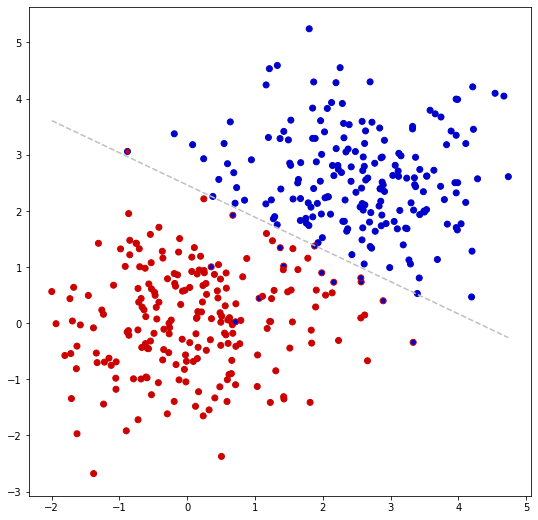

In [4]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

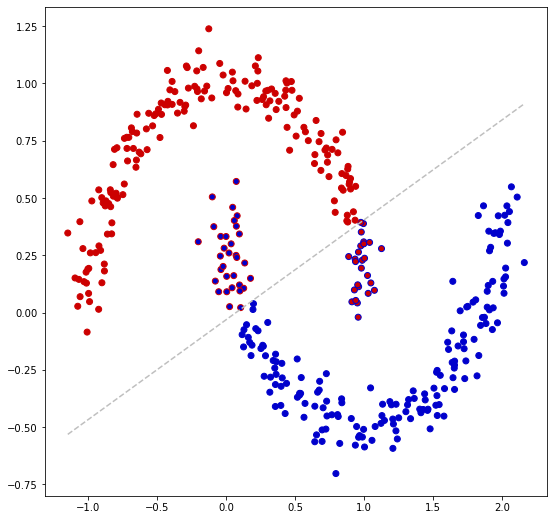

In [5]:
X, true_labels = make_moons(400, noise=0.075)
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

Проблема обычной реализации перцептрона в том, что закончить его обучение мы можем с неоптимальными весами, т.к. точность разбиения в зависимости от числа итераций не растет монотонно. Чтобы этого избежать, мы можем оставлять в конце веса той итерации, на которой мы лучше всего разбивали множество `X`.

Реализуем перцептрон с карманом.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. В конце обучения оставляет лучшие веса. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [6]:
class PerceptronBest:
    def __init__(self, iterations=100, lr=1):
        self.w = None
        self.iter = iterations
        self.lr = lr

    def fit(self, X, y):
        X = np.array(X)
        
        # Encoding labels as 0 and 1 for convenience
        self.labels = np.unique(y)
        y = [0 if label == self.labels[0] else 1 for label in y]
        
        # Adding constant dimension for w[0]
        X = np.hstack((np.ones((len(X), 1)), X))
        n_rows, n_cols = X.shape
        
        # Xavier init
        self.w = np.random.uniform(low=-1/np.sqrt(n_cols), high=1/np.sqrt(n_cols), size=n_cols)
        
        # Pocket implementation
        miss_count = np.sum((np.inner(X, self.w) > 0) != y)
        best_w = self.w

        for epoch in range(self.iter):
            for i in range(len(X)):
                pred = (np.inner(X[i], self.w) > 0)
                if (pred != y[i]):
                    self.w = self.w + self.lr * (y[i] - pred) * X[i]
                    
            # Saving best weights in the pocket
            cur_miss_count = np.sum((np.inner(X, self.w) > 0) != y)
            if (cur_miss_count < miss_count):
                miss_count = cur_miss_count
                best_w = self.w
                
        # Using pocketed weights            
        self.w = best_w
        

    def predict(self, X):
        # Needed preprocessing (from fit method)
        X = np.array(X)
        X = np.hstack((np.ones((len(X), 1)), X))
        y_pred = (np.inner(X, self.w) > 0)
        
        # Returning original labels
        y_pred = [self.labels[0] if pred == 0 else self.labels[1] for pred in y_pred]
        return y_pred

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

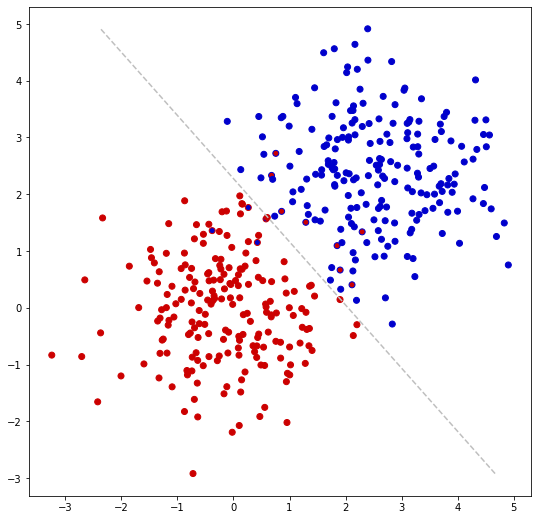

In [7]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

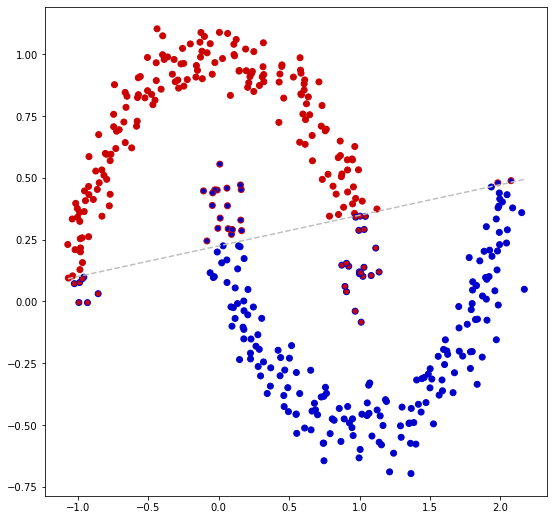

In [8]:
X, true_labels = make_moons(400, noise=0.075)
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

Реализуйте метод `transform_images(images)`, который преобразует изображения в двумерные векторы. Значение компонент векторов придумайте сами и напишите в виде комментария к методу.

In [9]:
def transform_images(images):
    # Scaling data
    new_images = images / 16.
    
    # Checking for 5's cap
    cap = np.sum(new_images[:, 0:1, :], axis=(1,2)) 
    
    # Difference between center part and left most part intesities 
    # Higher for 1s, because they are mostly concentrated in the center 
    # While 5s have more density on the left side
    right_side = np.sum(new_images[:, :, 3:6], axis=(1,2)) - np.sum(new_images[:, :, 0:2], axis=(1,2))
    new_images = np.vstack((cap, right_side)).T
    return new_images

def get_digits(train_image_ids, test_image_ids):
    data = datasets.load_digits()
    images_train, labels_train = data.images[train_image_ids['ImageId'].values], data.target[train_image_ids['ImageId'].values]
    images_test, labels_test = data.images[test_image_ids['ImageId'].values], data.target[test_image_ids['ImageId'].values]
    return images_train, labels_train, images_test, labels_test

def get_digits_by_mask(images, labels, y0, y1):
    mask = np.logical_or(labels == y0, labels == y1)
    labels = labels[mask]
    images = images[mask]
    images /= np.max(images)
    return images, labels

def get_x_y(train_image_ids, test_image_ids, y0=1, y1=5):
    X_train, y_train, X_test, y_test = get_digits(train_image_ids, test_image_ids)

    X_train, y_train = get_digits_by_mask(X_train, y_train, y0, y1)
    X_train = transform_images(X_train)

    X_test, y_test = get_digits_by_mask(X_test, y_test, y0, y1)
    X_test = transform_images(X_test)

    return X_train, y_train, X_test, y_test

Теперь посмотрим на точность обычного перцептрона и перцептрона выбором лучшей итерации. Для тестирования будем использовать цифры 1 и 5. Необходимо использовать реализованное выше преобразование, т.е. только векторы из 2х признаков. 

Точность хотя бы одного из классификаторов на тестовой выборке должна быть больше 80%

In [10]:
train_ids, test_ids = pd.read_csv("x_digits_train.csv"), pd.read_csv("x_digits_test.csv")
X_train, y_train, X_test, y_test = get_x_y(train_ids, test_ids)

In [11]:
c = Perceptron(iterations=100000)
c.fit(X_train, y_train)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

Accuracy: 0.9726027397260274


In [13]:
c = PerceptronBest(iterations=100000)
c.fit(X_train, y_train)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

Accuracy: 1.0


In [14]:
submission = pd.DataFrame(columns = ["Id", "Expected"])
submission["Id"] = test_ids['Id']
submission["Expected"] = c.predict(X_test)
submission.to_csv('submission.csv', index=False)

А теперь посчитаем среднюю точность по всем возможным парам цифр

In [15]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X_train, y_train, X_test, y_test = get_x_y(train_ids, test_ids, y0, y1)
    c = Perceptron(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X_train, y_train, X_test, y_test = get_x_y(train_ids, test_ids, y0, y1)
    c = PerceptronBest(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))